<a href="https://colab.research.google.com/github/HelloValentino/Factor-decomposition-project/blob/main/factor_attribution_global_equity_project_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================

# CELL 1: SETUP AND IMPORTS

# ==============================================================================

# Run this cell first to install and import all required packages

!pip install yfinance -q

import pandas as pd
import numpy as np
import yfinance as yf
import requests
from io import StringIO
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set visualization style

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All packages loaded successfully!")
print("=" * 80)
print("FACTOR EXPOSURE AND PERFORMANCE ATTRIBUTION ENGINE")
print("Global Equity Portfolio Analysis")
print("=" * 80)

# ==============================================================================


✓ All packages loaded successfully!
FACTOR EXPOSURE AND PERFORMANCE ATTRIBUTION ENGINE
Global Equity Portfolio Analysis


In [ ]:
# CELL 2: UPLOAD PORTFOLIO FILE

# ==============================================================================

# Upload your CSV file with columns: Ticker, Weight

print("\n[STEP 1] Upload Portfolio File")
print("-" * 80)
print("Instructions:")
print("1. Your CSV should have columns: 'Ticker' and 'Weight'")
print("2. Click 'Choose Files' when prompted")
print("3. Select your portfolio CSV file")
print("\nWaiting for file upload…")

from google.colab import files
uploaded = files.upload()
portfolio_file = list(uploaded.keys())[0]

# Determine file type and read accordingly
if portfolio_file.endswith('.csv'):
    portfolio = pd.read_csv(portfolio_file)
elif portfolio_file.endswith('.xlsx'):
    # Ensure openpyxl is installed for .xlsx files
    try:
        import openpyxl
    except ImportError:
        print("Installing openpyxl...")
        !pip install openpyxl -q
        import openpyxl
    portfolio = pd.read_excel(portfolio_file)
else:
    raise ValueError("Unsupported file format. Please upload a .csv or .xlsx file.")

print(f"\n✓ Portfolio loaded: {len(portfolio)} positions")
print(f"Total weight: {portfolio['Weight'].sum():.4f}")
print("\nPortfolio composition:")
print(portfolio.to_string(index=False))

# ==============================================================================



[STEP 1] Upload Portfolio File
--------------------------------------------------------------------------------
Instructions:
1. Your CSV should have columns: 'Ticker' and 'Weight'
2. Click 'Choose Files' when prompted
3. Select your portfolio CSV file

Waiting for file upload…


Saving portfolio.xlsx to portfolio.xlsx

✓ Portfolio loaded: 34 positions
Total weight: 1.0000

Portfolio composition:
     Ticker  Weight investment_date
       AAPL   0.025      2016-01-02
       SMCI   0.050      2016-01-02
      BUR.L   0.055      2016-01-02
   ALLFG.AS   0.010      2016-01-02
      DRX.L   0.020      2016-01-02
     LDO.MI   0.020      2016-01-02
      RIO.L   0.030      2016-01-02
    ZEAL.CO   0.050      2016-01-02
     6758.T   0.025      2016-01-02
  000270.KS   0.030      2016-01-02
       AUTL   0.025      2016-01-02
     PLUS.L   0.050      2016-01-02
     RHM.DE   0.055      2016-01-02
      MF.PA   0.010      2016-01-02
   ITSA4.SA   0.020      2016-01-02
    INDF.JK   0.020      2016-01-02
HDFCBANK.NS   0.030      2016-01-02
  105560.KS   0.050      2016-01-02
       NVDA   0.025      2016-01-02
       URTH   0.030      2016-01-02
        AGG   0.025      2016-01-02
     FBK.MI   0.025      2016-01-02
         GM   0.050      2016-01-02
     DNLM.L   0.0

In [ ]:
# CELL 3: ANALYZE PORTFOLIO EXCHANGES

# ==============================================================================

# Identify which stock exchanges your portfolio covers

print("\n" + "=" * 80)
print("PORTFOLIO EXCHANGE BREAKDOWN")
print("=" * 80)

def identify_exchange(ticker):
    """Identify stock exchange from ticker suffix"""
    if '.' not in ticker:
        return 'US'
    suffix = ticker.split('.')[-1]
    exchange_map = {
        'L': 'London (UK)', 'MI': 'Milan (Italy)', 'AS': 'Amsterdam (Netherlands)',
        'DE': 'Frankfurt (Germany)', 'PA': 'Paris (France)', 'T': 'Tokyo (Japan)',
        'KS': 'Korea', 'CO': 'Copenhagen (Denmark)', 'SW': 'Switzerland',
        'AX': 'Australia', 'JK': 'Jakarta (Indonesia)', 'SA': 'São Paulo (Brazil)',
        'LS': 'Santiago (Chile)', 'SZ': 'Shenzhen (China)', 'SS': 'Shanghai (China)'
    }
    return exchange_map.get(suffix, f'Other ({suffix})')

portfolio['Exchange'] = portfolio['Ticker'].apply(identify_exchange)
exchange_summary = portfolio.groupby('Exchange').agg({
    'Weight': ['sum', 'count']
}).round(4)
exchange_summary.columns = ['Total_Weight', 'Count']
exchange_summary = exchange_summary.sort_values('Total_Weight', ascending=False)

print("\nExchange Distribution:")
print(exchange_summary)

# ==============================================================================



PORTFOLIO EXCHANGE BREAKDOWN

Exchange Distribution:
                         Total_Weight  Count
Exchange                                    
US                              0.270      9
London (UK)                     0.235      6
Korea                           0.080      2
Frankfurt (Germany)             0.055      1
Switzerland                     0.050      1
Copenhagen (Denmark)            0.050      1
Milan (Italy)                   0.045      2
Paris (France)                  0.040      2
Tokyo (Japan)                   0.035      2
Other (NS)                      0.030      1
Shanghai (China)                0.020      1
Australia                       0.020      1
Jakarta (Indonesia)             0.020      1
São Paulo (Brazil)              0.020      1
Amsterdam (Netherlands)         0.010      1
Shenzhen (China)                0.010      1
Santiago (Chile)                0.010      1


In [ ]:
# ==============================================================================

#BATCH DOWNLOAD

# ==============================================================================

print("\n" + "=" * 80)
print("[STEP 2] Downloading Historical Prices - BATCH METHOD")
print("-" * 80)

start_date = '2015-12-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Date range: {start_date} to {end_date}")
print(f"Attempting batch download of {len(portfolio)} tickers…")
print("This may take 2-3 minutes…\n")

# Get all tickers as a list

tickers = portfolio['Ticker'].tolist()

# Method 1: batch download

print("Method 1: Batch download with yfinance…")
try:
    # Download all at once
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True,
        threads=True,
        progress=True
    )

    print("\n✓ Batch download complete!")

    # Extract adjusted close prices
    prices = pd.DataFrame()

    if len(tickers) == 1:
        # Single ticker case
        if 'Close' in data.columns:
            prices[tickers[0]] = data['Close']
    else:
        # Multiple tickers
        for ticker in tickers:
            try:
                if ticker in data.columns.get_level_values(0):
                    if 'Close' in data[ticker].columns:
                        prices[ticker] = data[ticker]['Close']
                    elif 'Adj Close' in data[ticker].columns:
                        prices[ticker] = data[ticker]['Adj Close']
            except:
                pass

    print(f"\n✓ Extracted prices for {len(prices.columns)} tickers")

except Exception as e:
    print(f"\n✗ Batch download failed: {str(e)[:100]}")
    print("\nTrying individual downloads as fallback…")

    # Method 2: Individual downloads as fallback
    prices = pd.DataFrame()

    for i, ticker in enumerate(tickers, 1):
        print(f"  [{i}/{len(tickers)}] {ticker:15s} ... ", end="", flush=True)
        try:
            tick_data = yf.download(ticker, start=start_date, end=end_date,
                                   progress=False, auto_adjust=True)
            if not tick_data.empty and 'Close' in tick_data.columns:
                prices[ticker] = tick_data['Close']
                print("✓")
            else:
                print("✗ (no data)")
        except Exception as e:
            print(f"✗ ({str(e)[:30]})")

# Summary

success_tickers = list(prices.columns)
failed_tickers = [t for t in tickers if t not in success_tickers]

print("\n" + "=" * 80)
print("DOWNLOAD SUMMARY")
print("=" * 80)
print(f"✓ Successful: {len(success_tickers)}/{len(tickers)} ({len(success_tickers)/len(tickers)*100:.1f}%)")
print(f"✗ Failed: {len(failed_tickers)}/{len(tickers)}")

if len(success_tickers) > 0:
    print(f"\n✓ Price data downloaded:")
    print(f"  Shape: {prices.shape[0]} days × {prices.shape[1]} stocks")
    print(f"  Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n  Successfully downloaded tickers:")
    for ticker in success_tickers[:20]:  # Show first 20
        print(f"    • {ticker}")
    if len(success_tickers) > 20:
        print(f"    … and {len(success_tickers) - 20} more")
else:
    print("\n⚠️ WARNING: No data downloaded!")
    print("\nPossible issues:")
    print("  1. Check internet connection")
    print("  2. Yahoo Finance may be blocking requests")
    print("  3. Ticker symbols may need correction")
    print("\nNext steps:")
    print("  • Wait 5 minutes and try again")
    print("  • Run the ‘Test Individual Tickers’ cell to diagnose")
    print("  • Verify ticker symbols on finance.yahoo.com")

if failed_tickers:
    print(f"\n✗ Failed tickers:")
    failed_df = portfolio[portfolio['Ticker'].isin(failed_tickers)]
    failed_weight = failed_df['Weight'].sum()
    print(f"  Total weight: {failed_weight:.3f}\n")

    for _, row in failed_df.iterrows():
        print(f"  • {row['Ticker']:15s} (Weight: {row['Weight']:.3f}, {row['Exchange']})")

    # Provide specific suggestions
    print("\n  Suggested fixes:")
    if 'HDFCBANK' in failed_tickers:
        print("    HDFCBANK → Try HDFCBANK.NS or HDFCBANK.BO")
    if any('.NS' in t for t in failed_tickers):
        print("    Indian stocks (.NS) → May need to use .BO instead")
    if any('URTH' in t or 'AGC' in t for t in failed_tickers):
        print("    US ETFs → Should work, check spelling")



[STEP 2] Downloading Historical Prices - BATCH METHOD
--------------------------------------------------------------------------------
Date range: 2015-12-01 to 2025-12-15
Attempting batch download of 34 tickers…
This may take 2-3 minutes…

Method 1: Batch download with yfinance…


[*********************100%***********************]  34 of 34 completed



✓ Batch download complete!

✓ Extracted prices for 34 tickers

DOWNLOAD SUMMARY
✓ Successful: 34/34 (100.0%)
✗ Failed: 0/34

✓ Price data downloaded:
  Shape: 2622 days × 34 stocks
  Date range: 2015-12-01 to 2025-12-12

  Successfully downloaded tickers:
    • AAPL
    • SMCI
    • BUR.L
    • ALLFG.AS
    • DRX.L
    • LDO.MI
    • RIO.L
    • ZEAL.CO
    • 6758.T
    • 000270.KS
    • AUTL
    • PLUS.L
    • RHM.DE
    • MF.PA
    • ITSA4.SA
    • INDF.JK
    • HDFCBANK.NS
    • 105560.KS
    • NVDA
    • URTH
    … and 14 more


In [ ]:
# CELL 5: CALCULATE MONTHLY RETURNS

# ==============================================================================

# Convert daily prices to monthly returns

print("\n" + "=" * 80)
print("[STEP 3] Calculating Monthly Returns")
print("-" * 80)

# Resample to monthly (end of month)

monthly_prices = prices.resample('M').last()

# Calculate monthly returns

monthly_returns = monthly_prices.pct_change().dropna()

# Filter to start from Jan 2016

monthly_returns = monthly_returns[monthly_returns.index >= '2016-01-31']

print(f"✓ Monthly return series created")
print(f"  Shape: {monthly_returns.shape[0]} months × {monthly_returns.shape[1]} stocks")
print(f"  Period: {monthly_returns.index[0].strftime('%Y-%m')} to {monthly_returns.index[-1].strftime('%Y-%m')}")

# Check for missing data

missing_data = monthly_returns.isnull().sum()
if missing_data.any():
    print(f"\n⚠ Data quality issues:")
    for ticker in missing_data[missing_data > 0].index:
        pct = missing_data[ticker] / len(monthly_returns) * 100
        exchange = portfolio[portfolio['Ticker'] == ticker]['Exchange'].values[0]
        print(f"  • {ticker:15s}: {missing_data[ticker]:3d} missing months ({pct:.1f}%) - {exchange}")



[STEP 3] Calculating Monthly Returns
--------------------------------------------------------------------------------
✓ Monthly return series created
  Shape: 56 months × 34 stocks
  Period: 2021-05 to 2025-12


In [ ]:
# ==============================================================================

# CELL 6: CALCULATE PORTFOLIO RETURNS

# ==============================================================================

# Calculate weighted portfolio returns (buy-and-hold, no rebalancing)

print("\n" + "=" * 80)
print("[STEP 4] Calculating Portfolio Returns (Buy & Hold)")
print("-" * 80)

# Get weights for available tickers

weights = portfolio.set_index('Ticker')['Weight']
available_tickers = [t for t in weights.index if t in monthly_returns.columns]
unavailable_tickers = [t for t in weights.index if t not in monthly_returns.columns]

if unavailable_tickers:
    print(f"\n⚠ Excluding {len(unavailable_tickers)} tickers without data:")
    for ticker in unavailable_tickers:
        weight = weights[ticker]
        exchange = portfolio[portfolio['Ticker'] == ticker]['Exchange'].values[0]
        print(f"  • {ticker:15s} (Weight: {weight:.3f}, {exchange})")

# Normalize weights

weights_aligned = weights[available_tickers]
original_weight_sum = weights_aligned.sum()
weights_aligned = weights_aligned / weights_aligned.sum()

print(f"\n✓ Portfolio constructed with {len(available_tickers)} stocks")
print(f"  Original weight coverage: {original_weight_sum:.3f}")
print(f"  Renormalization factor: {1/original_weight_sum:.3f}")

# Display final weights

print(f"\nFinal portfolio weights (top 10):")
weights_df = pd.DataFrame({
    'Ticker': weights_aligned.index,
    'Weight': weights_aligned.values,
    'Exchange': [portfolio[portfolio['Ticker']==t]['Exchange'].values[0] for t in weights_aligned.index]
}).sort_values('Weight', ascending=False)
print(weights_df.head(10).to_string(index=False))

# Calculate portfolio returns

portfolio_returns = (monthly_returns[available_tickers] * weights_aligned).sum(axis=1)
portfolio_returns.name = 'Portfolio'

# Calculate cumulative returns

cumulative_returns = (1 + portfolio_returns).cumprod()

# Performance statistics

total_return = (cumulative_returns.iloc[-1] - 1) * 100
annualized_return = (1 + portfolio_returns.mean())**12 - 1
annualized_vol = portfolio_returns.std() * np.sqrt(12)

print(f"\n" + "=" * 80)
print("PORTFOLIO PERFORMANCE")
print("=" * 80)
print(f"Period: {monthly_returns.index[0].strftime('%Y-%m')} to {monthly_returns.index[-1].strftime('%Y-%m')}")
print(f"Number of months: {len(portfolio_returns)}")
print(f"\nReturns:")
print(f"  Avg monthly return:      {portfolio_returns.mean():7.2%}")
print(f"  Annualized return:       {annualized_return:7.2%}")
print(f"  Total return:            {total_return:7.2%}")
print(f"\nRisk:")
print(f"  Monthly volatility:      {portfolio_returns.std():7.2%}")
print(f"  Annualized volatility:   {annualized_vol:7.2%}")
print(f"\nValue:")
print(f"  Growth of $1:            ${cumulative_returns.iloc[-1]:7.2f}")



[STEP 4] Calculating Portfolio Returns (Buy & Hold)
--------------------------------------------------------------------------------

✓ Portfolio constructed with 34 stocks
  Original weight coverage: 1.000
  Renormalization factor: 1.000

Final portfolio weights (top 10):
   Ticker  Weight             Exchange
   RHM.DE   0.055  Frankfurt (Germany)
    BUR.L   0.055          London (UK)
   DNLM.L   0.055          London (UK)
     SMCI   0.050                   US
105560.KS   0.050                Korea
   PLUS.L   0.050          London (UK)
       GM   0.050                   US
  LISP.SW   0.050          Switzerland
  ZEAL.CO   0.050 Copenhagen (Denmark)
     URTH   0.030                   US

PORTFOLIO PERFORMANCE
Period: 2021-05 to 2025-12
Number of months: 56

Returns:
  Avg monthly return:        1.76%
  Annualized return:        23.31%
  Total return:            15461.49%

Risk:
  Monthly volatility:        4.04%
  Annualized volatility:    14.01%

Value:
  Growth of $1:        

In [ ]:
# CELL 7: DOWNLOAD FAMA-FRENCH FACTORS

# ==============================================================================

# Download the 6 factors from Kenneth French Data Library

print("\n" + "=" * 80)
print("[STEP 5] Downloading Fama-French Factors")
print("-" * 80)

def download_ff_factors():
    """Download FF5 + Momentum from Kenneth French Data Library"""

    ff5_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'
    mom_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip'

    try:
        print("  Downloading Fama-French 5 Factors... ", end="")
        ff5_data = pd.read_csv(ff5_url, compression='zip', skiprows=3)

        ff5_data = ff5_data.rename(columns={ff5_data.columns[0]: 'Date'})
        # Robust filtering for YYYYMM format and conversion
        ff5_data['Date'] = ff5_data['Date'].astype(str).str.strip() # Strip whitespace
        ff5_data = ff5_data[ff5_data['Date'].str.match(r'^\d{6}$')] # Match exactly 6 digits
        ff5_data['Date'] = pd.to_datetime(ff5_data['Date'], format='%Y%m')
        ff5_data['Date'] = ff5_data['Date'] + pd.tseries.offsets.MonthEnd(0) # Adjust to month end
        ff5_data = ff5_data.set_index('Date')
        ff5_data = ff5_data.apply(pd.to_numeric, errors='coerce') / 100
        print("✓")

        print("  Downloading Momentum Factor... ", end="")
        mom_data = pd.read_csv(mom_url, compression='zip', skiprows=13)
        mom_data = mom_data.rename(columns={mom_data.columns[0]: 'Date'})
        # Robust filtering for YYYYMM format and conversion
        mom_data['Date'] = mom_data['Date'].astype(str).str.strip() # Strip whitespace
        mom_data = mom_data[mom_data['Date'].str.match(r'^\d{6}$')] # Match exactly 6 digits
        mom_data['Date'] = pd.to_datetime(mom_data['Date'], format='%Y%m')
        mom_data['Date'] = mom_data['Date'] + pd.tseries.offsets.MonthEnd(0) # Adjust to month end
        mom_data = mom_data.set_index('Date')
        mom_data = mom_data.apply(pd.to_numeric, errors='coerce') / 100
        print("✓")

        # Debugging: Print mom_data columns to identify the correct Momentum column name
        print(f"  Momentum data columns: {mom_data.columns.tolist()}")

        # Use a more robust way to select the momentum column, e.g., by checking if 'Mom' is in the name
        # Or, if we know the first non-Date column is Momentum, select it by index
        # For now, let's assume it's the first non-Date column after renaming and re-indexing
        factors = pd.concat([ff5_data, mom_data[['Mom']]], axis=1) # Corrected column name to 'Mom'
        factors.columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM']

        return factors

    except Exception as e:
        print(f"\n✗ Error: {e}")
        return None

factors = download_ff_factors()

if factors is not None:
    factors = factors[factors.index.isin(portfolio_returns.index)]
    print(f"\n✓ Factors aligned: {len(factors)} months")

    print(f"\nFactor statistics (annualized):")
    factor_stats = pd.DataFrame({
        'Mean': factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']].mean() * 12,
        'Std Dev': factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']].std() * np.sqrt(12)
    })
    print(factor_stats.round(3))



[STEP 5] Downloading Fama-French Factors
--------------------------------------------------------------------------------
  Momentum data columns: ['Mom']

✓ Factors aligned: 54 months

Factor statistics (annualized):
         Mean  Std Dev
Mkt-RF  0.093    0.160
SMB    -0.071    0.104
HML     0.038    0.147
RMW     0.049    0.092
CMA     0.005    0.106
MOM     0.050    0.124


In [ ]:
# CELL 8: CALCULATE EXCESS RETURNS

# ==============================================================================

# Subtract risk-free rate from portfolio returns

print("\n" + "=" * 80)
print("[STEP 6] Calculating Excess Returns")
print("-" * 80)

portfolio_excess = portfolio_returns - factors['RF']
portfolio_excess.name = 'Portfolio_Excess'

avg_rf = factors['RF'].mean() * 12
sharpe_ratio = portfolio_excess.mean() / portfolio_excess.std() * np.sqrt(12)

print(f"✓ Excess returns calculated")
print(f"  Avg risk-free rate (ann.):    {avg_rf:7.2%}")
print(f"  Avg excess return (monthly):  {portfolio_excess.mean():7.2%}")
print(f"  Avg excess return (ann.):     {portfolio_excess.mean() * 12:7.2%}")
print(f"  Sharpe ratio (annualized):    {sharpe_ratio:7.2f}")

# ==============================================================================



[STEP 6] Calculating Excess Returns
--------------------------------------------------------------------------------
✓ Excess returns calculated
  Avg risk-free rate (ann.):      3.31%
  Avg excess return (monthly):    1.57%
  Avg excess return (ann.):      18.83%
  Sharpe ratio (annualized):       1.34


In [ ]:
# CELL 9: ROLLING FACTOR REGRESSION

# ==============================================================================

# Run 36-month rolling regression to get time-varying factor loadings

print("\n" + "=" * 80)
print("[STEP 7] Running Rolling Factor Regression")
print("-" * 80)

window = 36  # 3 years

print(f"Window: {window} months")
print("\nRationale:")
print("  • 36 observations provides stable estimates")
print("  • Responsive to portfolio drift (buy-and-hold)")
print("  • Standard for factor analysis")

X = factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
y = portfolio_excess

data = pd.concat([y, X], axis=1).dropna()
y_aligned = data[['Portfolio_Excess']]
X_aligned = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
X_aligned_const = sm.add_constant(X_aligned)

print(f"\nRunning rolling OLS regression…")
print(f"Sample size: {len(data)} months")
print("(This may take 30-60 seconds…)\n")

model = RollingOLS(y_aligned, X_aligned_const, window=window)
rolling_results = model.fit()

factor_loadings = rolling_results.params.iloc[:, 1:]
alphas = rolling_results.params['const']

print(f"✓ Rolling regression complete")
print(f"  Periods with estimates: {len(factor_loadings)}")
print(f"  First estimate: {factor_loadings.index[0].strftime('%Y-%m')}")
print(f"  Last estimate: {factor_loadings.index[-1].strftime('%Y-%m')}")

print(f"\n" + "=" * 80)
print("AVERAGE FACTOR LOADINGS (BETAS)")
print("=" * 80)
for factor in factor_loadings.columns:
    mean = factor_loadings[factor].mean()
    std = factor_loadings[factor].std()
    print(f"{factor:<10} Mean: {mean:6.3f}  Std: {std:6.3f}")

print(f"\nAlpha:")
print(f"  Mean monthly alpha: {alphas.mean():7.4f} ({alphas.mean()*12:.2%} ann.)")
print(f"  t-statistic:        {alphas.mean() / alphas.std() * np.sqrt(len(alphas)):7.2f}")



[STEP 7] Running Rolling Factor Regression
--------------------------------------------------------------------------------
Window: 36 months

Rationale:
  • 36 observations provides stable estimates
  • Responsive to portfolio drift (buy-and-hold)
  • Standard for factor analysis

Running rolling OLS regression…
Sample size: 54 months
(This may take 30-60 seconds…)

✓ Rolling regression complete
  Periods with estimates: 54
  First estimate: 2021-05
  Last estimate: 2025-10

AVERAGE FACTOR LOADINGS (BETAS)
Mkt-RF     Mean:  0.747  Std:  0.014
SMB        Mean:  0.025  Std:  0.082
HML        Mean:  0.077  Std:  0.079
RMW        Mean: -0.044  Std:  0.078
CMA        Mean: -0.023  Std:  0.093
MOM        Mean: -0.066  Std:  0.033

Alpha:
  Mean monthly alpha:  0.0137 (16.48% ann.)
  t-statistic:          45.37


In [ ]:
# CELL 10: PERFORMANCE ATTRIBUTION

# ==============================================================================

# Decompose excess return into factor contributions

print("\n" + "=" * 80)
print("[STEP 8] PERFORMANCE ATTRIBUTION")
print("=" * 80)

avg_loadings = factor_loadings.mean()
avg_factor_returns = X.mean()
factor_contributions = avg_loadings * avg_factor_returns * 12  # Annualized
avg_alpha = alphas.mean() * 12
total_attributed = factor_contributions.sum() + avg_alpha
actual_excess = portfolio_excess.mean() * 12

print(f"\nActual Excess Return (ann.):  {actual_excess:>7.2%}")
print(f"Total Attributed Return:      {total_attributed:>7.2%}")
print(f"Attribution Error:            {actual_excess - total_attributed:>7.2%}")

print(f"\n{'Factor':<12} {'Loading':>10} {'Return':>10} {'Contribution':>14}")
print("-" * 70)
for factor in factor_contributions.index:
    print(f"{factor:<12} {avg_loadings[factor]:>10.3f} {avg_factor_returns[factor]*12:>9.2%} "
          f"{factor_contributions[factor]:>13.2%}")
print(f"{'Alpha':<12} {'' :>10} {'' :>10} {avg_alpha:>13.2%}")
print("-" * 70)
print(f"{'TOTAL':<12} {'' :>10} {'' :>10} {total_attributed:>13.2%}")



[STEP 8] PERFORMANCE ATTRIBUTION

Actual Excess Return (ann.):   18.83%
Total Attributed Return:       22.97%
Attribution Error:             -4.15%

Factor          Loading     Return   Contribution
----------------------------------------------------------------------
Mkt-RF            0.747     9.27%         6.93%
SMB               0.025    -7.10%        -0.17%
HML               0.077     3.78%         0.29%
RMW              -0.044     4.86%        -0.21%
CMA              -0.023     0.49%        -0.01%
MOM              -0.066     5.00%        -0.33%
Alpha                                     16.48%
----------------------------------------------------------------------
TOTAL                                     22.97%



Creating Plot 1: Rolling Factor Loadings…


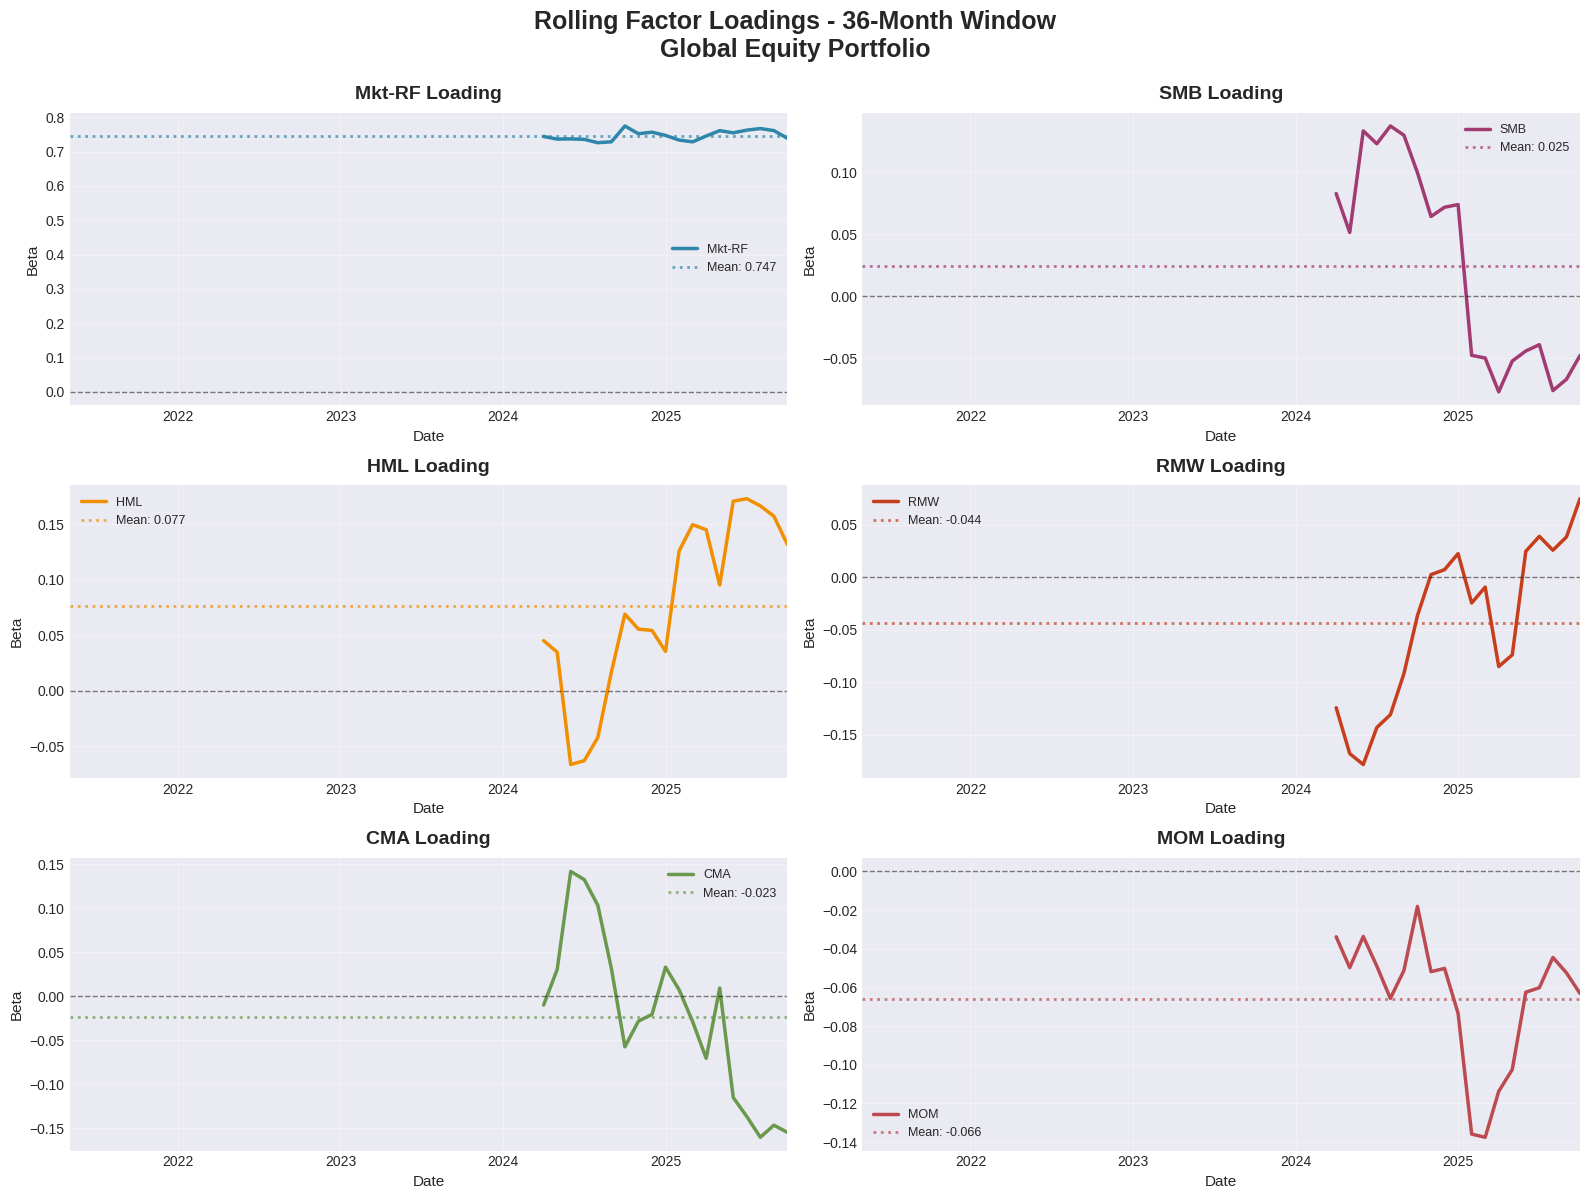

✓ Saved: factor_loadings_timeseries.png


In [ ]:
# CELL 11: PLOT 1 - ROLLING FACTOR LOADINGS

# ==============================================================================

# Visualize how factor exposures change over time

print("\nCreating Plot 1: Rolling Factor Loadings…")

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Rolling Factor Loadings - 36-Month Window\nGlobal Equity Portfolio',
             fontsize=18, fontweight='bold', y=0.995)

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']

for idx, (factor, color) in enumerate(zip(factor_loadings.columns, colors)):
    ax = axes[idx // 2, idx % 2]
    factor_loadings[factor].plot(ax=ax, linewidth=2.5, color=color)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

    mean_val = factor_loadings[factor].mean()
    ax.axhline(y=mean_val, color=color, linestyle=':', alpha=0.7, linewidth=2,
               label=f'Mean: {mean_val:.3f}')

    ax.set_title(f'{factor} Loading', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Beta', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('factor_loadings_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: factor_loadings_timeseries.png")



Creating Plot 2: Performance Attribution…


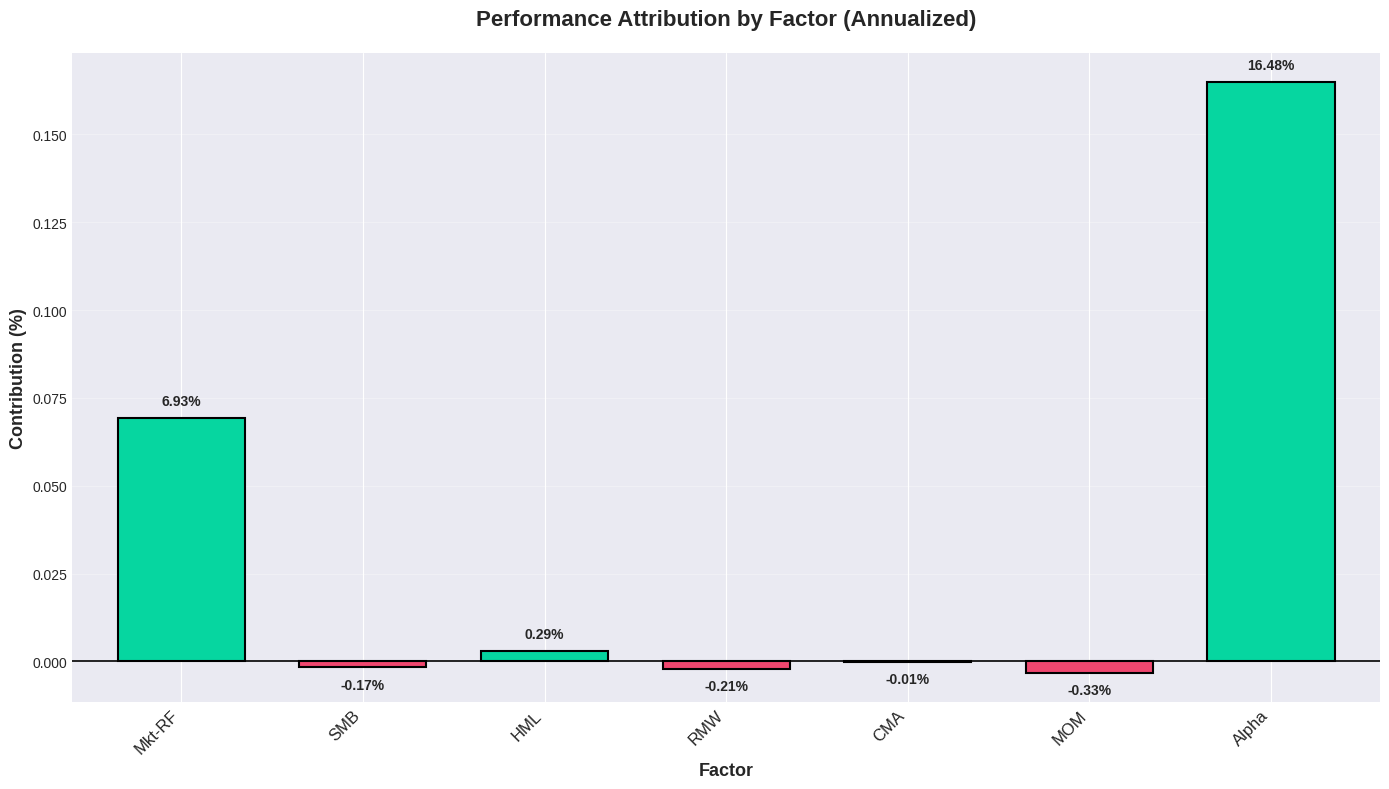

✓ Saved: performance_attribution.png


In [ ]:
# CELL 12: PLOT 2 - PERFORMANCE ATTRIBUTION

# ==============================================================================

# Bar chart showing each factor’s contribution to returns

print("\nCreating Plot 2: Performance Attribution…")

fig, ax = plt.subplots(figsize=(14, 8))

attribution_data = pd.concat([
    factor_contributions,
    pd.Series({'Alpha': avg_alpha})
])

colors_attr = ['#06D6A0' if x >= 0 else '#EF476F' for x in attribution_data]
attribution_data.plot(kind='bar', ax=ax, color=colors_attr,
                      edgecolor='black', linewidth=1.5, width=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
ax.set_title('Performance Attribution by Factor (Annualized)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Factor', fontsize=13, fontweight='bold')
ax.set_ylabel('Contribution (%)', fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, (label, value) in enumerate(attribution_data.items()):
    offset = 0.003 if value >= 0 else -0.003
    va = 'bottom' if value >= 0 else 'top'
    ax.text(i, value + offset, f'{value:.2%}',
            ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_attribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: performance_attribution.png")



Creating Plot 3: Cumulative Returns…


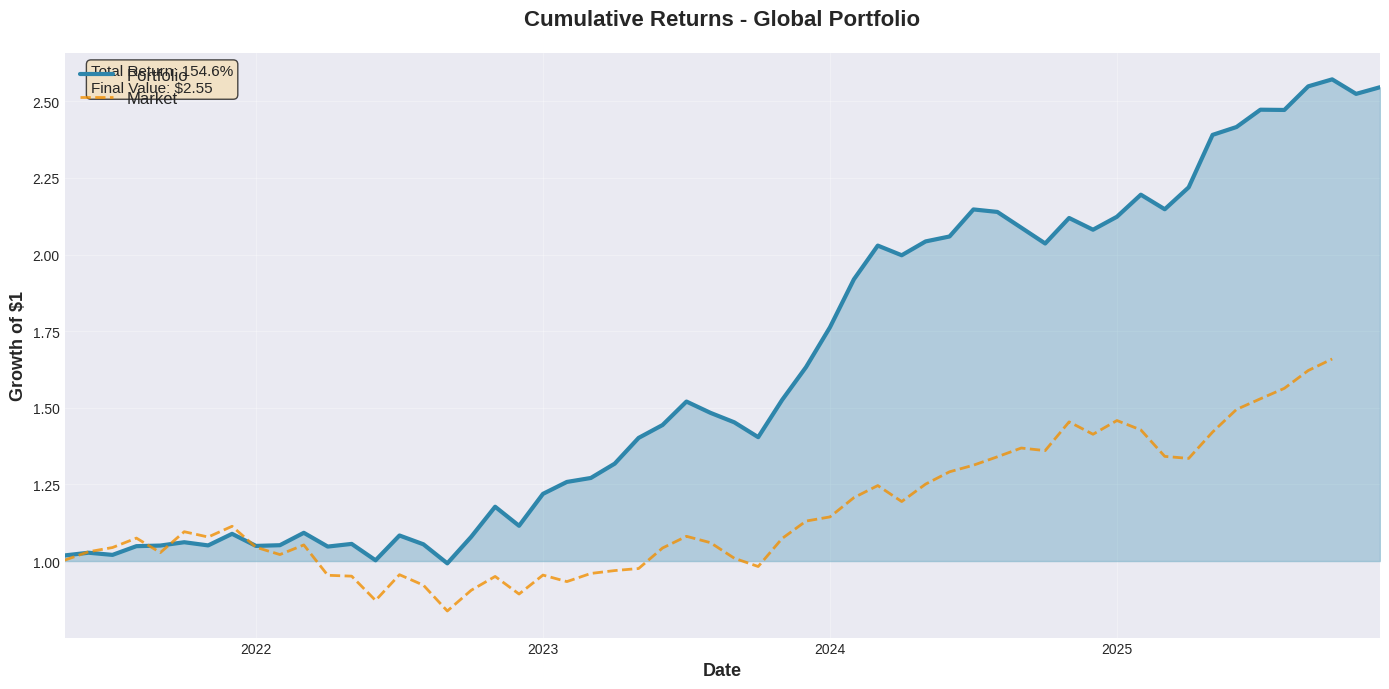

✓ Saved: cumulative_returns.png


In [ ]:
# CELL 13: PLOT 3 - CUMULATIVE RETURNS

# ==============================================================================

# Show portfolio growth over time vs. market benchmark

print("\nCreating Plot 3: Cumulative Returns…")

fig, ax = plt.subplots(figsize=(14, 7))

cumulative_returns.plot(ax=ax, linewidth=3, color='#2E86AB', label='Portfolio')
ax.fill_between(cumulative_returns.index, 1, cumulative_returns, alpha=0.3, color='#2E86AB')

# Add market benchmark

if 'Mkt-RF' in factors.columns:
    market_cumulative = (1 + factors['Mkt-RF'] + factors['RF']).cumprod()
    market_cumulative = market_cumulative[market_cumulative.index.isin(cumulative_returns.index)]
    market_cumulative.plot(ax=ax, linewidth=2, color='#F18F01',
                           linestyle='--', label='Market', alpha=0.8)

ax.set_title('Cumulative Returns - Global Portfolio',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Growth of $1', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

final_value = cumulative_returns.iloc[-1]
info_text = f'Total Return: {(final_value-1)*100:.1f}%\nFinal Value: ${final_value:.2f}'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: cumulative_returns.png")



Creating Plot 4: Return Distribution…


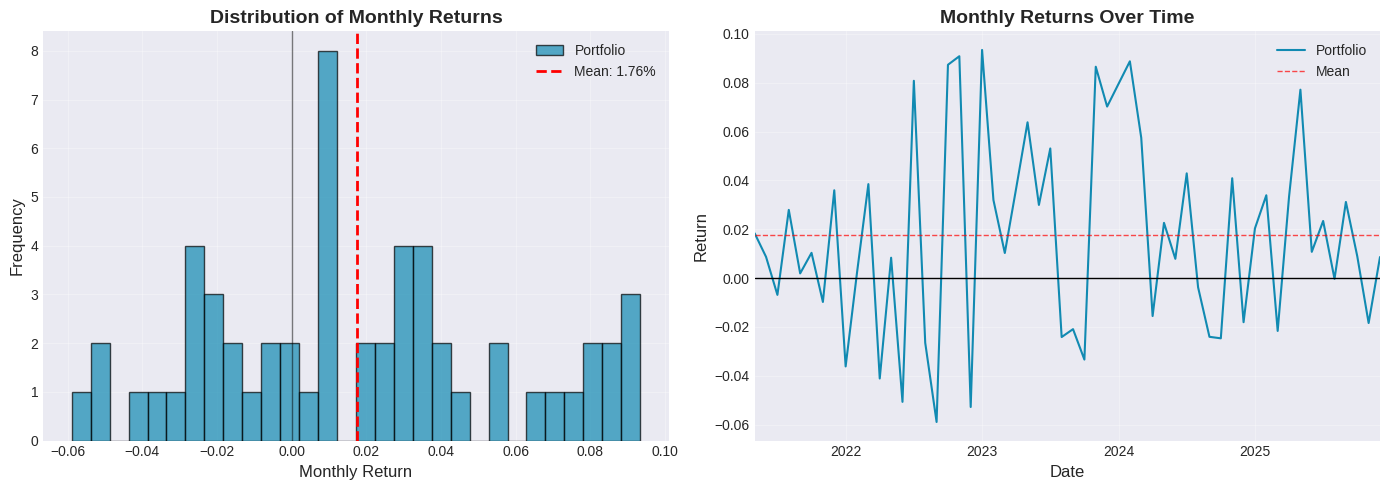

✓ Saved: return_distribution.png


In [ ]:
# CELL 14: PLOT 4 - RETURN DISTRIBUTION

# ==============================================================================

# Histogram and time series of monthly returns

print("\nCreating Plot 4: Return Distribution…")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

portfolio_returns.plot(kind='hist', bins=30, ax=ax1, color='#118AB2',
                      edgecolor='black', alpha=0.7)
ax1.axvline(portfolio_returns.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {portfolio_returns.mean():.2%}')
ax1.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_title('Distribution of Monthly Returns', fontsize=14, fontweight='bold')
ax1.set_xlabel('Monthly Return', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

portfolio_returns.plot(ax=ax2, linewidth=1.5, color='#118AB2')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axhline(y=portfolio_returns.mean(), color='red', linestyle='--',
            linewidth=1, alpha=0.7, label='Mean')
ax2.set_title('Monthly Returns Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Return', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('return_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: return_distribution.png")


In [ ]:
# CELL 15: EXPORT RESULTS TO CSV

# ==============================================================================

# Save all results to CSV files for further analysis

print("\n" + "=" * 80)
print("EXPORTING RESULTS")
print("=" * 80)

# Define common index for time series exports
# This ensures all series are aligned to the period where factor data is available
common_index = factors.index

# Export 1: Time series data
results_export = pd.DataFrame({
    'Date': common_index,
    'Portfolio_Return': portfolio_returns.loc[common_index].values,
    'Portfolio_Excess': portfolio_excess.loc[common_index].values,
    'Cumulative_Return': (1 + portfolio_returns.loc[common_index]).cumprod().values, # Recalculate cumulative returns for common_index
    'Risk_Free_Rate': factors.loc[common_index, 'RF'].values # This will now work
})

# Add factor loadings
for factor in factor_loadings.columns:
    results_export = results_export.merge(
        factor_loadings[[factor]].rename(columns={factor: f'Beta_{factor}'}),
        left_on='Date', right_index=True, how='left'
    )

results_export = results_export.merge(
    alphas.rename('Alpha'), left_on='Date', right_index=True, how='left'
)

results_export.to_csv('portfolio_analysis_results.csv', index=False)
print("✓ Saved: portfolio_analysis_results.csv")

# Export 2: Attribution summary (this part already uses avg_loadings, avg_factor_returns, avg_alpha which are based on aligned data)
# No change needed here for the Key Error.

# Export 3: Summary statistics
# Recalculate relevant stats based on common_index to ensure consistency
portfolio_returns_aligned = portfolio_returns.loc[common_index]
portfolio_excess_aligned = portfolio_excess.loc[common_index]
cumulative_returns_aligned = (1 + portfolio_returns_aligned).cumprod()

total_return_aligned = (cumulative_returns_aligned.iloc[-1] - 1) * 100
annualized_return_aligned = (1 + portfolio_returns_aligned.mean())**12 - 1
annualized_vol_aligned = portfolio_returns_aligned.std() * np.sqrt(12)
sharpe_ratio_aligned = portfolio_excess_aligned.mean() / portfolio_excess_aligned.std() * np.sqrt(12)
max_drawdown_aligned = ((cumulative_returns_aligned / cumulative_returns_aligned.cummax() - 1).min())


summary_stats = pd.DataFrame({
    'Metric': [
        'Start Date', 'End Date', 'Number of Months', 'Number of Positions',
        'Avg Monthly Return', 'Annualized Return', 'Total Return',
        'Monthly Volatility', 'Annualized Volatility', 'Sharpe Ratio',
        'Max Drawdown', 'Alpha (Annualized)'
    ],
    'Value': [
        portfolio_returns_aligned.index[0].strftime('%Y-%m'),
        portfolio_returns_aligned.index[-1].strftime('%Y-%m'),
        len(portfolio_returns_aligned),
        len(available_tickers),
        f"{portfolio_returns_aligned.mean():.4f}",
        f"{annualized_return_aligned:.4f}",
        f"{(cumulative_returns_aligned.iloc[-1] - 1):.4f}",
        f"{portfolio_returns_aligned.std():.4f}",
        f"{annualized_vol_aligned:.4f}",
        f"{sharpe_ratio_aligned:.4f}",
        f"{max_drawdown_aligned:.4f}",
        f"{avg_alpha:.4f}" # avg_alpha is already computed based on aligned data from RollingOLS
    ]
})
summary_stats.to_csv('summary_statistics.csv', index=False)
print("✓ Saved: summary_statistics.csv")



EXPORTING RESULTS
✓ Saved: portfolio_analysis_results.csv
✓ Saved: summary_statistics.csv
